## Robot Motion

1. Generating Smooth Paths
1. Control: PID Control

### Generating Smooth Paths
1. path as a sequence of points $x_i \in {x_0, ..., x_{n-1}} $
1. Algorithm
    1. create variable $y_i$ as all the $x_i$
    1. optimize
        1. smooth path: minimize $(x_i-y_i)^2 + \alpha (y_i-y_{i+1})^2$
            1. $\alpha$: weight data
                1. the stronger the $\alpha$ the smoother the path            
            1. minimize $(x_i-y_i)^2$ lead to original path 
            1. minimize $(y_i-y_{i+1})^2$ lead to no path, collapsed
        1. use gradient descent
            1. $y_i = y_i + \alpha(x_i - y_i) + \beta(y_{i+1} +y_{i-1}- 2y_i)$
                1. $y_i = y_i + \alpha(x_i - y_i)$ 
                1. $y_i = y_i + \beta(y_{i+1} - y_i)$
                    1. => $y_i = y_i - \beta(y_{i+1} +y_{i-1}- 2y_i)$
                1. $\beta$: weight smooth (0.1)
                1. $\alpha$: weight data (0.5)

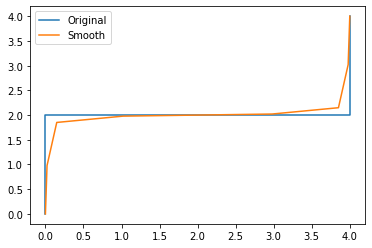

In [6]:
import copy
import numpy as np
from matplotlib import pyplot as plt


path = np.array([
    [0.0,0],
    [0,1],
    [0,2],
    [1,2],
    [2,2],
    [3,2],
    [4,2],
    [4,3],
    [4,4],
])

def smooth(path, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001):
    newpath = copy.deepcopy(path)
    change = tolerance
    while change >= tolerance:
        change = 0.0
        for i in range(1, len(path)-1): #no first and last 
            delta = weight_data * (path[i] - newpath[i]) + weight_smooth*(newpath[i-1] + newpath[i+1] - 2*newpath[i])
            newpath[i]+= delta
            change = np.sum(np.abs(delta)) 
            
    return newpath
newpath = smooth(path)
plt.plot(path.transpose()[0],path.transpose()[1])  
plt.plot(newpath.transpose()[0],newpath.transpose()[1]) 
plt.legend(["Original","Smooth"])
plt.show()

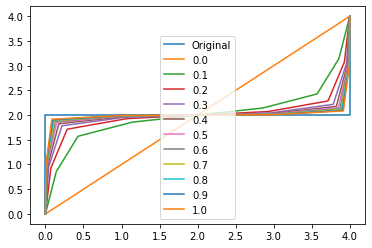

In [41]:
plt.plot(path.transpose()[0],path.transpose()[1])  
for i in range(0, 11, 1):
    weight_data = i/10
    newpath = smooth(path, weight_data = weight_data)
    plt.plot(newpath.transpose()[0],newpath.transpose()[1]) 

plt.legend(["Original","0.0","0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1.0"])
plt.show()

1. if a == 0, straight line
1. if $x_0, x_{n-1} changable$ => point

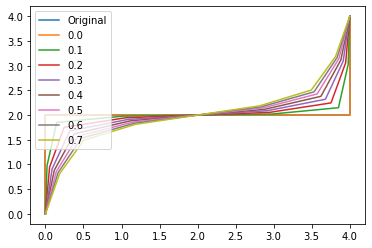

In [58]:
plt.plot(path.transpose()[0],path.transpose()[1])  
for i in range(0, 8, 1):
    weight_smooth = i/10
    newpath = smooth(path, weight_smooth = weight_smooth)
    plt.plot(newpath.transpose()[0],newpath.transpose()[1]) 

plt.legend(["Original","0.0","0.1","0.2","0.3","0.4","0.5","0.6","0.7"])
plt.show()

#### Obstacle
1. DP with a stochastic action funtion
1. add a term push away from obstacle by maximizing the distance between the nearest obstacle and data point

## PID Control
1. PID
    1. P: Proportional
    1. D: Differential 
    1. I: Integral
1. How to control a car
    1. steering constant
    1. randomely steering commands
    1. set the steering angle in proportion to (Good)        
        1. Cross track error (CTE)
            1. the lateral distance between the vehicle and the reference trajector
        1. the larger error, the more you need to turn toward the target trajectory

### P-Controller
1. P: Proportional
1. if steering angle is in proportion to CTE with a ratio of $\tau$
    1. the car will overshoots
    1. no matter how small $\tau$ is
    1. coz wheel straight but car is downward
    1. Marcinally stable: never converge

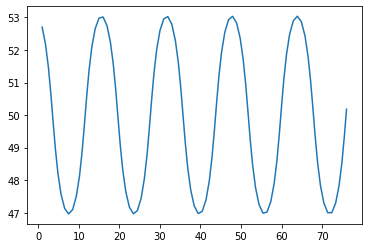

In [10]:
import sys
sys.path.append('../libs/Utilities')
from robot_pf import *
robot = robot()
robot.set(0.0, 51.0, 0.0)
def run(robot, tau, n=100, speed=1.0):
    x = []
    y = []
    for i in range(n):
        cte = robot.y-50
        steer = -tau*cte
        robot= robot.move(steer, speed)
        x.append(robot.x)
        y.append(robot.y)
    return x, y
x, y = run(robot, 0.1)
plt.plot(x, y) 


### PD-Control
1. $\alpha = -\tau_P CTE - \tau_D {d\over dt}CTE$
    1. ${d\over dt}CTE = CTE_t - CTE_{t-1}$

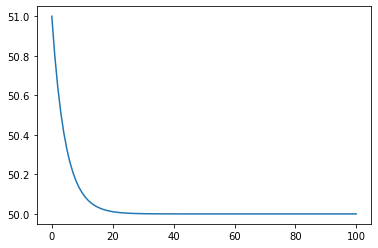

In [42]:
import sys
sys.path.append('../libs/Utilities')
from robot_pf import *
robot = robot()
robot.set(0.0, 51.0, 0.0)
def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x = []
    y = []
    
    x.append(robot.x)
    y.append(robot.y)
    last_y = robot.y
    for i in range(n):
        cte = robot.y-50
        diff = robot.y - last_y
        last_y = robot.y 
        steer = -tau_p*cte - tau_d*diff
        robot= robot.move(steer, speed)
#         print(steer, speed, cte, diff)
        x.append(robot.x)
        y.append(robot.y)
    return x, y
x, y = run(robot, 0.2, 1)
plt.plot(x, y) 


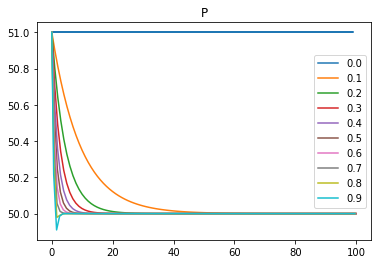

In [33]:
for i in range(10):
    p = i/10
    robot.set(0.0, 51.0, 0.0)
    x, y = run(robot, p, 1)
    plt.plot(x, y)
plt.legend(["0.0","0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9"])
plt.title("P")
plt.show()

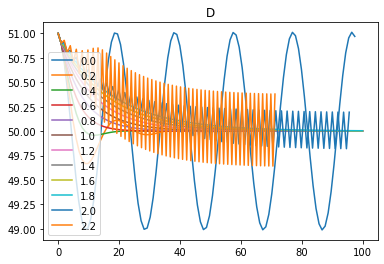

In [41]:
for i in range(12):
    robot.set(0.0, 51.0, 0.0)
    d = i/5
    x, y = run(robot, 0.1, d)
    plt.plot(x, y)
plt.legend(["0.0","0.2","0.4","0.6","0.8","1.0","1.2","1.4","1.6","1.8","2.0","2.2",])
plt.title("D")
plt.show()

### Systematic bias
1. Can the D-term solve the issue, if the wheel is not aligned?
    1. No
1. Error is measured by integral/sum of the crosstrack errors over time: $\sum CTE$
1. $\alpha = -\tau_P CTE - \tau_D {d\over dt}CTE - \tau_I\sum CTE$
    1. if we have a constant CTE, the last term will get larger and larger
    1. P: Proportional
    1. D: Differential 
    1. I: Integral

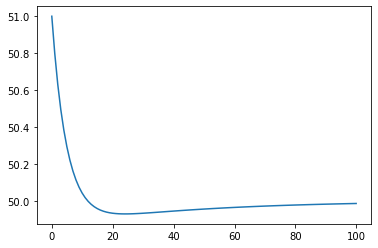

In [47]:
import sys
sys.path.append('../libs/Utilities')
from robot_pf import *
robot = robot()
robot.set(0.0, 51.0, 0.0)
# robot.set_steering_drift(10/180*pi)
def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x = []
    y = []
    
    x.append(robot.x)
    y.append(robot.y)
    last_y = robot.y
    ictr = 0
    for i in range(n):
        cte = robot.y-50
        ictr+=cte
        diff = robot.y - last_y
        last_y = robot.y 
        steer = -tau_p*cte - tau_d*diff - tau_i*ictr
        robot= robot.move(steer, speed)
#         print(steer, speed, cte, diff)
        x.append(robot.x)
        y.append(robot.y)
    return x, y
x, y = run(robot, 0.2, 1, 0.004)
plt.plot(x, y) 


### How can we find good control gains
1. Control gains: P,I,D parameters 
1. Twiddle: coordinate ascent
    1. have the run function to return average CTE to represent goodness
    1. set
        1. P = [0, 0, 0]
        1. dP = [1, 1, 1]
    1. best_err = run(p)
    1. for each coordinate in isolation
        1. moves parameter down a little bit by dp
        1. if it finds a better solution, it retains it, and it even increments the probing interval.
        1. if fails, goes back to the original and decreases our probing interval
        1. do the whole thing as long as the sume of the dp's is larger than the threshold

In [ ]:
p = [0, 0, 0]
dp = [1, 1, 1]
threshold = 0.00001
best_err = run(p)
while(sum(dp)>threshold):
    for i in range(3):
        p[i]+=dp[i]
        err = run(p)
        if(err<best_err):
            best_err = err
            dp[i]*=1.1
        else:
            p[i]-=2*dp[i]            
            err = run(p)
            if(err<best_err):
                best_err = err
                dp[i]*=1.1
            else:
                p[i] += dp[i]
                dp[i]*=0.9

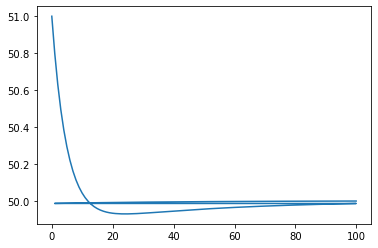

In [61]:
import sys
sys.path.append('../libs/Utilities')
from robot_pf import *
def run(P, n=100, speed=1.0):
    x = []
    y = []
    
    rbt = robot()
    rbt.set(0.0, 51.0, 0.0)
    
    x.append(rbt.x)
    y.append(rbt.y)
    last_y = rbt.y
    ictr = 0
    tctr = 0
    for i in range(2*n):
        cte = rbt.y-50
        ictr+=cte
        diff = rbt.y - last_y
        last_y = rbt.y 
        steer = -P[0]*cte - P[1]*diff - P[2]*ictr
        rbt= rbt.move(steer, speed)
#         print(steer, speed, cte, diff)
        x.append(rbt.x)
        y.append(rbt.y)
        if(i>=n):
            tctr+=abs(cte)
    return x, y, tctr/n
x, y, e = run([0.2, 1, 0.004])
plt.plot(x, y) 


In [62]:
def twiddle(tol=0.001):
    p = [0, 0, 0]
    dp = [1, 1, 1]
    output = []
    x, y, best_err = run(p)
    while(sum(dp)>tol):
        output.append(best_err)
        for i in range(3):
            p[i]+=dp[i]
            x, y, err = run(p)
            if(err<best_err):
                best_err = err
                dp[i]*=1.1
            else:
                p[i]-=2*dp[i]            
                x, y, err = run(p)
                if(err<best_err):
                    best_err = err
                    dp[i]*=1.1
                else:
                    p[i] += dp[i]
                    dp[i]*=0.9
    return output

plt.plot(twiddle())

ValueError: Orientation must be in [0..2pi]

switch off terms
1. I
    1. error will get larger and harder to converge 
    1. it's for systematic bias
1. D
    1. error get large error and fail to converge
    1. even without sysemtatic bias

### Summary
1. Discrete path => Smoth path
1. Control PID